In [1]:
# https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html
# https://discuss.pytorch.org/t/will-tensor-to-float32-to-float16-lose-precision-or-values/145264
# https://docs.pytorch.org/docs/stable/nn.functional.html
# https://docs.pytorch.org/docs/stable/generated/torch.Tensor.element_size.html
# https://medium.com/biased-algorithms/guide-to-gradient-clipping-in-pytorch-f1db24ea08a2

 # how things are stored

tensors can be represented in memory as:
- strided --> we see it here
- sparse  --> usefull when the matrix stored has a lot of zeros (ex. image with a lot of white pixels), in that case we store only the location of the non zero values
- ...



In [2]:
# https://blog.ezyang.com/2019/05/pytorch-internals/

In [3]:
import torch

In [4]:
a = torch.tensor([[1,2,3,4],[5,6,7,8],[9,10,11,12]])
a

tensor([[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12]])

In [5]:
# a tensor is stored as a contiguous "string" in the memory
a.stride(), a.shape # in order to pass from one element to another in one row we add 1, to pass from one element to another in columns we have to add 4
# 0 1 2 3 4 5 6 7 8  9 10 11 --> index
# 1,2,3,4,5,6,7,8,9,10,11,12

# to access the element 10 we have to add 1 stride[1] (=1) and 2 stride[0] (=4)
#                 |
#                 V
# 0 1 2 3 4 5 6 7 8  9 10 11 --> index in memory
# 1,2,3,4,5,6,7,8,9,10,11,12 --> added 2 stride 4 we move 8 to the right

# then we add 1 to move to the ninht element
#                    |
#                    V
# 0 1 2 3 4 5 6 7 8  9 10 11 --> index in memory
# 1,2,3,4,5,6,7,8,9,10,11,12

# when we can move using the stride the vector is contigous
# A contiguous tensor means you can walk through memory with its stride() without jumps or gaps.

((4, 1), torch.Size([3, 4]))

In [6]:
# when we change the dimensions of it, we are just changing the STRIDE, that is the "steps" that are between each element row and column based
a_ = a.view(4,3)
a_

tensor([[ 1,  2,  3],
        [ 4,  5,  6],
        [ 7,  8,  9],
        [10, 11, 12]])

In [7]:
a_.stride() #

(3, 1)

In [8]:
print(a.is_contiguous()) # is contiguous tells us if we can access the elements of the tensor like before
print(a.stride())
print(a)

True
(4, 1)
tensor([[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12]])


### slicing

In [9]:
# PyTorch does not copy the data. It makes a view into the same memory as a
b = a[:,0:2] # in this case we are taking of the tensor a only the first 2 elements of each row
b

tensor([[ 1,  2],
        [ 5,  6],
        [ 9, 10]])

In [10]:
print(b.is_contiguous()) # b is no longer contiguous, because it contains "GAPs"
print(b.stride())
# index        0  1  2  3  4  5  6  7  8   9  10  11
# a’s memory:  1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
# b points to: 1, 2, -, -, 5, 6, -, -, 9, 10, -,   -
#                    ^ gaps (the 3rd and 4th column are skipped from a)

False
(4, 1)


#### PyTorch does not copy the data. It makes a view into the same memory as a


In [11]:
# .storage().data_ptr()--> returns the memory address of the tensor --> It’s the same kind of address you’d see in C/C++ if you did &array[0].
# https://docs.pytorch.org/docs/stable/generated/torch.Tensor.data_ptr.html

# this is because pytorch stores raw numbers in a contiguous memory buffer and slices are views (no copy)

# In normal python instead lists are:
#      a dynamic array of pointers.
#      Each slot holds a reference to a Python object (not the value itself).
#      Example: [1, 2, 3] → the list object has 3 slots → each slot points to a separate Python int object.
#      Slicing a list (a[1:3]) makes a new list with copies of those references. It doesn’t share memory with the original.

In [12]:
b.storage().data_ptr() # as we can see here the address in memory of the first element of b is:

/tmp/ipython-input-4272416585.py:1: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  b.storage().data_ptr() # as we can see here the address in memory of the first element of b is:


394657664

In [13]:
a.storage().data_ptr() # it is the same as a:

394657664

In [14]:
c = a.clone()

In [15]:
c.storage().data_ptr() # here c is copied, thus the address is different

394864128

# intro

In [16]:
import torch

In [17]:
torch.cuda.is_available()

True

In [18]:
device = torch.cuda.device(0).idx

In [19]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [20]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15095MB, multi_processor_count=40, uuid=f73e9713-5fb1-6108-8a7e-c8821ea43fcf, pci_bus_id=0, pci_device_id=4, pci_domain_id=0, L2_cache_size=4MB)

In [21]:
free, total = torch.cuda.mem_get_info(0)
print(f"free {free/1024**3}")
print(f"total {total/1024**3}")

free 14.6407470703125
total 14.74127197265625


In [22]:
free, total = torch.cuda.mem_get_info(0)
print(f"free {free}")
print(f"total {total}")

free 15720382464
total 15828320256


In [23]:
matrix_a = torch.tensor([[1,2],[4,5],[7,8]], device =device )

In [24]:
free, total = torch.cuda.mem_get_info(0)
print(f"free {free}")
print(f"total {total}")

free 15718285312
total 15828320256


In [25]:
matrix_b = torch.tensor([[1,0,1],[1,1,0],[0,1,1]])

In [26]:
matrix_a.size(), matrix_b.size()

(torch.Size([3, 2]), torch.Size([3, 3]))

In [27]:
matrix_a @ matrix_b # matrix product not possible

RuntimeError: Expected all tensors to be on the same device, but got mat2 is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA_mm)

In [28]:
matrix_a.device, matrix_b.device

(device(type='cuda', index=0), device(type='cpu'))

In [29]:
matrix_b.to(device) # copies and puts in device
matrix_b.device

device(type='cpu')

In [30]:
matrix_b = matrix_b.to(device) # create a copy on the cuda device
matrix_b.device

device(type='cuda', index=0)

In [31]:
free, total = torch.cuda.mem_get_info(0)
print(f"free {free}")
print(f"total {total}")

free 15718285312
total 15828320256


In [32]:
matrix_a @ matrix_b # matrix product not possible because mismatch

RuntimeError: mat1 and mat2 shapes cannot be multiplied (3x2 and 3x3)

In [33]:
transposed_matrix_a = matrix_a.T
transposed_matrix_a.size(), transposed_matrix_a.device

(torch.Size([2, 3]), device(type='cuda', index=0))

In [34]:
matrix_a[0][0].type(), matrix_b[0][0].type() # this type is not gona work, convert into a float32, 16...

('torch.cuda.LongTensor', 'torch.cuda.LongTensor')

In [35]:
transposed_matrix_a = torch.tensor([[1,2],[4,5],[7,8]], device =device, dtype=torch.float16 ).T
matrix_b = torch.tensor([[1,0,1],[1,1,0],[0,1,1]], device = device, dtype=torch.float16)

In [36]:
matrix_product = transposed_matrix_a @ matrix_b
matrix_product

tensor([[ 5., 11.,  8.],
        [ 7., 13., 10.]], device='cuda:0', dtype=torch.float16)

 # memory

In [37]:
matrix_product.element_size()*8 # bits, element_size() returns bytes, each byte is 8 bit

16

In [38]:
matrix_product.element_size() # number of bytes

2

In [39]:
matrix_product.nelement()

6

In [40]:
matrix_product.element_size()*8*matrix_product.nelement()

96

In [41]:
int64_matrix = torch.tensor([[ 5, 11,  8],
        [ 7, 13, 10]], device='cuda:0', dtype=torch.int64)

In [42]:
int64_matrix.element_size() # bytes

8

In [43]:
int64_matrix.element_size()*8 # bits

64

In [44]:
matrix_product.nelement()*matrix_product.element_size()*8 # dimension of a 2*3 matrix of float16

96

In [45]:
int64_matrix.nelement()*int64_matrix.element_size()*8 # dimension of a 2*3 matrix of int64

384

In [46]:
def get_free_mem():
    free, total = torch.cuda.mem_get_info(0)
    return free

free_before = get_free_mem()

test = torch.tensor([[8., 11., 8.],
                     [7., 13., 10.]],
                    device='cuda:0', dtype=torch.float16)

free_after = get_free_mem()

used_mem = free_before - free_after

tensor_bytes = test.nelement() * test.element_size()

print(f"Free before: {free_before / 1024**2:.2f} MB")
print(f"Free after:  {free_after / 1024**2:.2f} MB")
print(f"Used memory: {used_mem / 1024**2:.6f} MB")
print(f"Tensor size: {tensor_bytes} bytes ({tensor_bytes / 1024**2:.6f} MB)")
print(f"Difference:  {used_mem - tensor_bytes} bytes")
# PyTorch’s CUDA allocator doesn’t necessarily ask the GPU for memory each time you create a small tensor.

Free before: 14942.12 MB
Free after:  14942.12 MB
Used memory: 0.000000 MB
Tensor size: 12 bytes (0.000011 MB)
Difference:  -12 bytes


In [47]:
def get_free_mem():
    free, total = torch.cuda.mem_get_info(0)
    return free

free_before = get_free_mem()

big = torch.empty((1024, 1024, 1024), device='cuda:0', dtype=torch.float16)  # ~2 GB
free_after = get_free_mem()

used_mem = free_before - free_after

tensor_bytes = big.nelement() * big.element_size()

print(f"Free before: {free_before / 1024**2:.2f} MB")
print(f"Free after:  {free_after / 1024**2:.2f} MB")
print(f"Used memory: {used_mem / 1024**2:.6f} MB")
print(f"Tensor size: {tensor_bytes} bytes ({tensor_bytes / 1024**2:.6f} MB)")
print(f"Difference:  {used_mem - tensor_bytes} bytes")
# PyTorch’s CUDA allocator doesn’t necessarily ask the GPU for memory each time you create a small tensor.
# When you run your code, PyTorch already has a pre-allocated memory pool on the GPU

Free before: 14942.12 MB
Free after:  12894.12 MB
Used memory: 2048.000000 MB
Tensor size: 2147483648 bytes (2048.000000 MB)
Difference:  0 bytes


In [48]:
del big # PyTorch keeps the freed block in its internal pool for reuse


In [49]:
torch.cuda.empty_cache() # tells PyTorch to release unused memory from its caching allocator back to the CUDA driver


In [50]:
import gc
import torch

objs = [obj for obj in gc.get_objects()
        if torch.is_tensor(obj) and obj.is_cuda]

for o in objs:
    print(type(o), o.size(), o.dtype, o.device, "| bits: ", o.element_size() * o.nelement()*8,"| bytes: ", o.element_size() * o.nelement())


<class 'torch.Tensor'> torch.Size([3, 2]) torch.float16 cuda:0 | bits:  96 | bytes:  12
<class 'torch.Tensor'> torch.Size([2, 3]) torch.float16 cuda:0 | bits:  96 | bytes:  12
<class 'torch.Tensor'> torch.Size([3, 3]) torch.float16 cuda:0 | bits:  144 | bytes:  18
<class 'torch.Tensor'> torch.Size([2, 3]) torch.float16 cuda:0 | bits:  96 | bytes:  12
<class 'torch.Tensor'> torch.Size([2, 3]) torch.int64 cuda:0 | bits:  384 | bytes:  48
<class 'torch.Tensor'> torch.Size([2, 3]) torch.float16 cuda:0 | bits:  96 | bytes:  12
<class 'torch.Tensor'> torch.Size([3, 2]) torch.int64 cuda:0 | bits:  384 | bytes:  48


/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1125: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)


In [51]:
torch.cuda.memory_allocated(0) #counts all bytes that PyTorch has marked as in use for tensors on the GPU.

8522752

In [52]:
allocated_memory = torch.cuda.memory_allocated(0)
dimensions = []
for o in objs:
    dim = o.element_size() * o.nelement()*8
    dimensions.append(dim)
sum(dimensions) #only covers tensors that Python’s garbage collector can still see.

1296

In [53]:
allocated_memory-sum(dimensions) #some PyTorch ops allocate small auxiliary buffers that aren’t exposed as normal tensors

8521456

# another way for matrix mult

In [54]:
import torch.nn as nn

In [55]:
linear = nn.Linear(in_features = 3, out_features=4).requires_grad_(False) # W: (4, 3), b: (4,)

In [56]:
linear.weight.size(),linear.bias.size()

(torch.Size([4, 3]), torch.Size([4]))

In [57]:
# when we make train or make inference, we like to do it in batches, example, a batch of 2 elements, each with 3 features;
batches = torch.tensor([[1,2,3],[4,5,6]], dtype = torch.float32)

In [58]:
linear(batches) # this is equivalent to the operation below

tensor([[ 0.2258, -0.4995,  0.2714,  1.0519],
        [ 0.2344, -0.6997,  2.0046,  2.3773]])

In [59]:
batches @ linear.weight.T + linear.bias

tensor([[ 0.2258, -0.4995,  0.2714,  1.0519],
        [ 0.2344, -0.6997,  2.0046,  2.3773]])

In [60]:
linear_without_bias = nn.Linear(in_features = 3, out_features=4, bias=False).requires_grad_(False) # W: (4, 3), b: (4,)
linear_without_bias.bias

# add non linearity

In [61]:
batches = torch.tensor([[1,2,3],[4,5,6]], dtype = torch.float32)

In [62]:
linear = nn.Linear(in_features = 3, out_features=4).requires_grad_(False) # W: (4, 3), b: (4,)
relu = nn.ReLU()

In [63]:
linear_result = linear(batches)
non_linear = relu(linear_result)
non_linear

tensor([[2.6648, 0.0000, 0.0000, 2.1199],
        [5.4047, 0.0000, 0.0000, 5.1321]])

# import data

In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [65]:
data = pd.read_csv("sample_data/mnist_train_small.csv", header=None)

In [66]:
dataset, dataset_test = train_test_split(data, test_size=0.05)

In [67]:
dataset.shape,dataset_test.shape

((19000, 785), (1000, 785))

In [68]:
dataset.reset_index(inplace = True, drop = True), dataset_test.reset_index(inplace = True,drop = True)

(None, None)

In [69]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
dataset.iloc[0] # index lock the first row

,0
0,1
1,0
2,0
3,0
4,0
...,...
780,0
781,0
782,0
783,0


In [71]:
Y_train, X_train = dataset.iloc[:,0], dataset.iloc[:, 1:] # get all the rows of the zeroth column, and all the rows from the first column on

In [72]:
X_train.iloc[0,:] # let's see one example

,0
1,0
2,0
3,0
4,0
5,0
...,...
780,0
781,0
782,0
783,0


In [73]:
example = torch.tensor(X_train.iloc[0,:].to_numpy())

In [74]:
reshaped_example = example.view([28,28]) # view is very usefull to reshape tensors

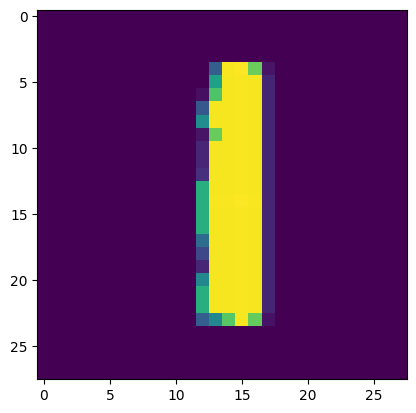

In [75]:
plt.imshow(reshaped_example)

# the PyTorch way

In [76]:
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

In [77]:
Y_train, X_train = torch.tensor(dataset.iloc[:,0].to_numpy()).to(device), torch.tensor(dataset.iloc[:, 1:].to_numpy(),dtype = torch.float32).to(device)
Y_test, X_test = torch.tensor(dataset_test.iloc[:,0].to_numpy()).to(device), torch.tensor(dataset_test.iloc[:, 1:].to_numpy(),dtype = torch.float32).to(device)

In [78]:
Y_train_one_hot = F.one_hot(Y_train, 10).to(torch.float16)
Y_test_one_hot = F.one_hot(Y_test, 10).to(torch.float16)
Y_train_one_hot[0]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       dtype=torch.float16)

In [79]:
train_loader = DataLoader(TensorDataset(X_train, Y_train_one_hot), batch_size=128, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, Y_test_one_hot), batch_size=128, shuffle=True)

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], device='cuda:0',
       dtype=torch.float16)

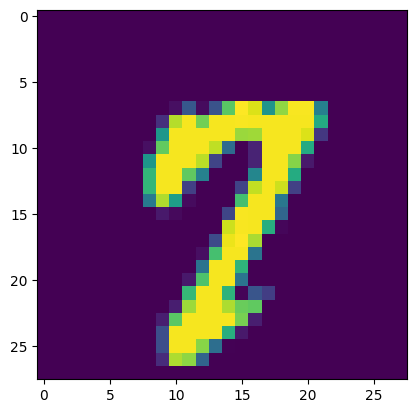

In [80]:
input,target = next(iter(train_loader))
plt.imshow(input[0].view(28,28).to("cpu"))
target[0]

# Model

In [81]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.fc1 = nn.Linear(28**2, 28**2*4)
        self.fc2 = nn.Linear(28**2*4, 28**2*4)
        self.fc3 = nn.Linear(28**2*4, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

In [82]:
model = MLP()

In [83]:
[p.shape for p in model.parameters()] # weight, bias, weight, bias...

[torch.Size([3136, 784]),
 torch.Size([3136]),
 torch.Size([3136, 3136]),
 torch.Size([3136]),
 torch.Size([10, 3136]),
 torch.Size([10])]

In [84]:
[p.device for p in model.parameters()]



[device(type='cpu'),
 device(type='cpu'),
 device(type='cpu'),
 device(type='cpu'),
 device(type='cpu'),
 device(type='cpu')]

In [85]:
model.to(device)
[p.device for p in model.parameters()] # all in cuda device

[device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0)]

In [86]:
[p.requires_grad for p in model.parameters()] # all requires grad True

[True, True, True, True, True, True]

In [87]:
print(model)

MLP(
  (fc1): Linear(in_features=784, out_features=3136, bias=True)
  (fc2): Linear(in_features=3136, out_features=3136, bias=True)
  (fc3): Linear(in_features=3136, out_features=10, bias=True)
)


## pay attention to dimensions

In [88]:
# make predictions and check confidence of the model
input,target = next(iter(train_loader))
output, target = model(input[0:2]), target[0:2]
# confidence is low, infact the model gives random gibberish as for the results
output

tensor([[ -5.4973,  10.3431,   6.8945,   2.9943, -19.6836,  -3.5454,   0.4817,
          -2.1445,  -4.3881,  16.2558],
        [-19.8731,  12.2602,  -1.7504,   3.7559,  -6.5974,  -2.0768,  -7.8852,
           4.1525,   6.7537,  12.3867]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [89]:
output.size()

torch.Size([2, 10])

In [90]:
output[0].softmax(-1) # we want to calculate softmax along each element in the batch, so we want to do it on
           # the second of the 2 dimensions above, not the first
           #        NOT THIS ONE
           #          |
           #          V
           # [
               # [ -4.0369,  -4.3247, -10.1753,   0.1598,  -2.9019,   4.0838,   7.7013, 2.9484, -12.1731,  -3.8176] <-- along this dimension
               # [ -5.4059, -11.0881, -21.5375,  -6.6593,   1.3501,  -1.0939,   3.1066, -1.9324,  -1.4153,  -7.6667]
            #]


tensor([3.5607e-10, 2.6973e-03, 8.5743e-05, 1.7352e-06, 2.4574e-16, 2.5073e-09,
        1.4066e-07, 1.0177e-08, 1.0795e-09, 9.9722e-01], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [91]:
output.softmax(dim = 0) # this is wrong, we are calcualting across elements in the batches!

tensor([[1.0000e+00, 1.2819e-01, 9.9982e-01, 3.1829e-01, 2.0735e-06, 1.8714e-01,
         9.9977e-01, 1.8384e-03, 1.4493e-05, 9.7955e-01],
        [5.7101e-07, 8.7181e-01, 1.7600e-04, 6.8171e-01, 1.0000e+00, 8.1286e-01,
         2.3237e-04, 9.9816e-01, 9.9999e-01, 2.0449e-02]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [92]:
output.softmax(dim = -1) # as we can see this is the same as the result we obtained 2 cells above, thus it is the correct one

tensor([[3.5607e-10, 2.6973e-03, 8.5743e-05, 1.7352e-06, 2.4574e-16, 2.5073e-09,
         1.4066e-07, 1.0177e-08, 1.0795e-09, 9.9722e-01],
        [5.1807e-15, 4.6742e-01, 3.8459e-07, 9.4699e-05, 3.0198e-09, 2.7749e-07,
         8.3304e-10, 1.4080e-04, 1.8980e-03, 5.3045e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [93]:
output.softmax(dim = 1) # when we have multple elements in each batch, we can just indicate the dimension,
# if there is only one element, just use -1

tensor([[3.5607e-10, 2.6973e-03, 8.5743e-05, 1.7352e-06, 2.4574e-16, 2.5073e-09,
         1.4066e-07, 1.0177e-08, 1.0795e-09, 9.9722e-01],
        [5.1807e-15, 4.6742e-01, 3.8459e-07, 9.4699e-05, 3.0198e-09, 2.7749e-07,
         8.3304e-10, 1.4080e-04, 1.8980e-03, 5.3045e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

# model confidence

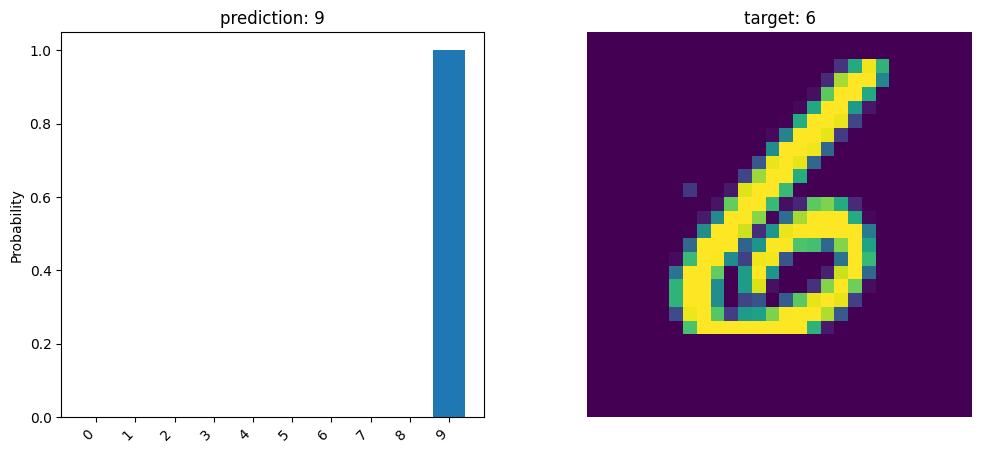

In [94]:
# make predictions and check confidence of the model
input,target = next(iter(train_loader))
output, target = model(input[0]), target[0]
# confidence is low, infact the model gives random gibberish as for the results
output= output.softmax(dim = -1)
vals = output.detach().cpu().numpy()


fig,ax = plt.subplots(1,2, figsize =( 12,5))

ax[0].bar(range(len(vals)), vals)
ax[0].set_xticks(range(10))
ax[0].set_xticklabels(range(10), rotation=45, ha='right')
ax[0].set_ylabel("Probability")
ax[0].set_title(f"prediction: {torch.argmax(output, dim = -1)}")
ax[1].imshow(input[0].view(28,28).to("cpu"))
ax[1].set_title(f"target: {torch.argmax(target, dim=-1)}")
ax[1].set_axis_off()
plt.show()

In [95]:
input,target = next(iter(train_loader))

In [96]:
output = model(input[0])

In [97]:
output.size()

torch.Size([10])

In [98]:
output = output.view(1,10)
output.size(),output.softmax(dim = 1)

(torch.Size([1, 10]),
 tensor([[1.8197e-13, 1.0041e-06, 4.2301e-08, 1.9346e-10, 5.0672e-13, 1.4018e-12,
          4.4237e-10, 8.6930e-06, 2.2727e-13, 9.9999e-01]], device='cuda:0',
        grad_fn=<SoftmaxBackward0>))

In [99]:
sum(output.softmax(dim = 1)[0]) # output is softmax

tensor(1.0000, device='cuda:0', grad_fn=<AddBackward0>)

In [100]:
output_batch = model(input) # we can give the model entire batches, to train or to infer

In [101]:
output_batch

tensor([[ -6.9297,   8.5939,   5.4268,  ...,  10.7523,  -6.7074,  22.4053],
        [-11.8993,   3.1539,   3.7284,  ...,   1.1799,   2.0267,  10.3703],
        [ -7.8521,   9.4876,   6.8656,  ...,  -1.9922,   0.4655,   7.8985],
        ...,
        [-14.0204,  -0.6786,  -2.6072,  ...,  14.0428,  -1.7763,  19.8286],
        [ -3.8903,   4.6032,   5.1098,  ...,  11.9453,   0.3700,  21.9499],
        [-11.2866,  13.3012,   5.5558,  ...,  19.0742,  -8.9280,  14.9386]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [102]:
output_batch.size()

torch.Size([128, 10])

# train the model

In [103]:
criterion = nn.CrossEntropyLoss()

In [104]:
output = model(input)
loss = criterion(output,target)
float(loss.detach())

13.935954093933105

In [105]:
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-30, weight_decay= 1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay= 1)

In [106]:
max_norm = 1.0  # Define a threshold
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

tensor(0.)

In [107]:
loss_s_train = []
loss_s_test = []
test = True

In [108]:
print(float(loss))
for _ in range(10):
  optimizer.zero_grad()
  input,target = next(iter(train_loader))

  output = model(input)

  loss = criterion(output,target)

  loss.backward()
  optimizer.step()
  print(float(loss.detach()))
  if test:
    input_test,target_test = next(iter(test_loader))
    output_test = model(input_test)
    loss_test = criterion(output_test, target_test)
    loss_s_test.append(float(loss_test.detach()))
  loss_s_train.append(float(loss.detach()))


/tmp/ipython-input-3392716510.py:1: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  print(float(loss))


13.935954093933105
14.948424339294434
9.390448570251465
7.31874418258667
5.99265193939209
5.599588871002197
5.755127906799316
4.9040446281433105
5.176251411437988
4.052838325500488
3.1158299446105957


Text(0.5, 1.0, 'test loss')

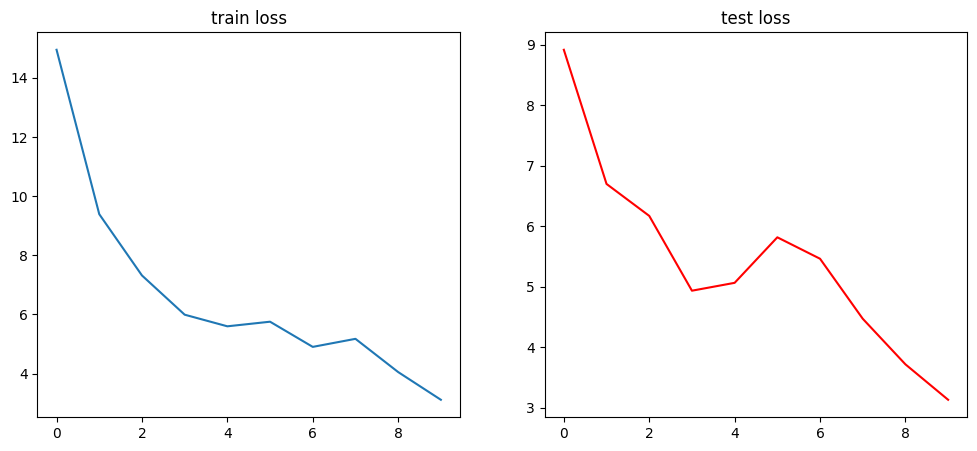

In [109]:
fig,ax = plt.subplots(1,2, figsize =( 12,5))

ax[0].plot(loss_s_train)
ax[0].set_title("train loss")

ax[1].plot(loss_s_test, color = "red")
ax[1].set_title("test loss")


# try on the train set

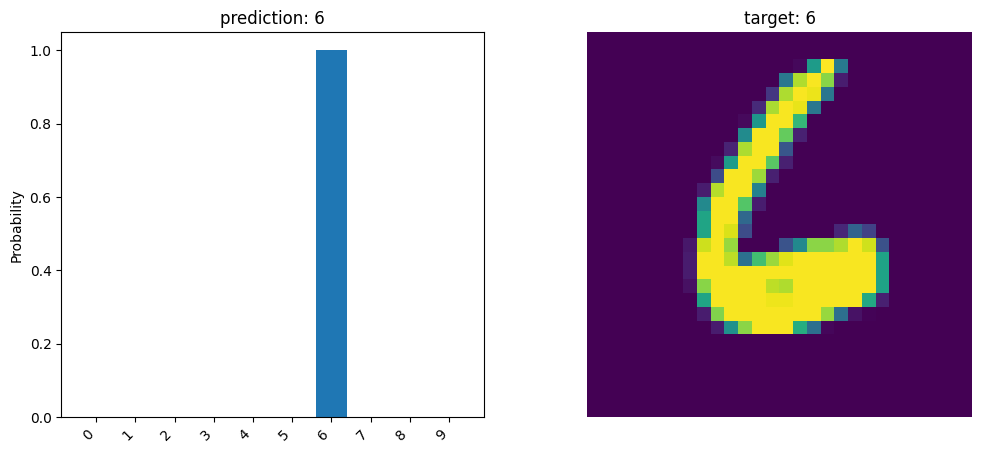

In [110]:
input,target = next(iter(train_loader))

input_example = input[0]
target_example = target[0]
train_example_output, train_example_target = model(input_example),target_example


train_example_output = train_example_output.softmax(dim = -1)
vals = train_example_output.detach().cpu().numpy()

fig,ax = plt.subplots(1,2, figsize =( 12,5))

ax[0].bar(range(len(vals)), vals)
ax[0].set_xticks(range(10))
ax[0].set_xticklabels(range(10), rotation=45, ha='right')
ax[0].set_ylabel("Probability")
ax[0].set_title(f"prediction: {torch.argmax(train_example_output, dim = -1)}")
ax[1].imshow(input[0].view(28,28).to("cpu"))
ax[1].set_title(f"target: {torch.argmax(target_example, dim=-1)}")
ax[1].set_axis_off()
plt.show()

# try on the test set

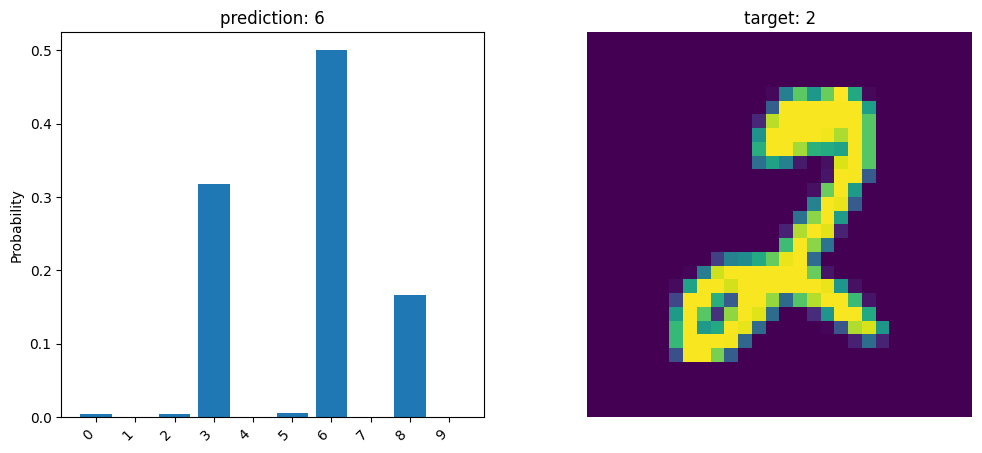

In [111]:
input,target = next(iter(test_loader))

input_example = input[0]
target_example = target[0]
test_example_output, test_example_target = model(input_example),target_example


test_example_output = test_example_output.softmax(dim = -1)
vals = test_example_output.detach().cpu().numpy()

fig,ax = plt.subplots(1,2, figsize =( 12,5))

ax[0].bar(range(len(vals)), vals)
ax[0].set_xticks(range(10))
ax[0].set_xticklabels(range(10), rotation=45, ha='right')
ax[0].set_ylabel("Probability")
ax[0].set_title(f"prediction: {torch.argmax(test_example_output, dim = -1)}")
ax[1].imshow(input[0].view(28,28).to("cpu"))
ax[1].set_title(f"target: {torch.argmax(target_example, dim=-1)}")
ax[1].set_axis_off()
plt.show()

In [ ]:
torch.save(model.state_dict(), "models/model.pth")